<h2> Part 1 <h2/>

<h4> First question to answer and its motivation <h4/>
<li> Question: what kind of insurance package could the customer purchase, basic, extend or basic? 
<li> Motivation: 
As a insurance company locate and provide service in the USA, the most important question to be answer is, "what is the customers' risk preference and how much would he or she invest on the motor insurance?" , so when we construct the recommendation system we can allocate the most appropriate and optimal price to our potential customers and maximize the profit.





<h4>Possible Solution</h4>
<li>train classifier (random forest; SVM; etc)
<li>neural network

In [119]:
# package imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns
import sklearn.metrics as metricss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# read data
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
data = pd.read_csv('after_merge.csv')
df = data.copy()
df.set_index('Customer', inplace= True) #the customer number is irelative with the classification so set it as index
df = df.iloc[:, 1:] #eliminate the unnamed column
df.head()

,State Abbreviation,Accident Severity in State,Number of Accidents in State,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
Customer,,,,,,,,,,,,,,,,,,,,,,,,,,
BU79786,WA,2.305062,32554,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
QZ44356,AZ,2.069553,56504,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
AI49188,NV,2.226077,6197,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
WW63253,CA,2.041998,795868,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
HB64268,WA,2.305062,32554,Washington,2813.692575,No,Basic,Bachelor,3/2/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [120]:
df['Coverage'].value_counts()

Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64

In [121]:
#since we don't know about the when did the insurance started, so effective to date doesn't make much sense
df.drop(['Effective To Date'], axis = 1, inplace = True)

In [122]:
#functionalize the process of encoding the categorical variables
def encode(df):
    df['Coverage'] = df['Coverage'].map({'Premium': 3, 'Extended': 2, 'Basic': 1})

    data_type_dict = dict(df.dtypes)
    cat_list = [ele for ele in data_type_dict.keys() if data_type_dict[ele] == 'object']
    num_list = [ele for ele in data_type_dict.keys() if data_type_dict[ele] != 'object']
    if 'Coverage' in num_list:
        num_list.remove('Coverage')

    #encode/scale data    
    df = pd.get_dummies(df, columns = cat_list)
    
    return df, cat_list, num_list
    


In [123]:
df_transfered, cat_list, num_list = encode(df)
print(cat_list, '\n')
print(num_list, '\n')

df_transfered.head() #encoded data


['State Abbreviation', 'State', 'Response', 'Education', 'EmploymentStatus', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size'] 

['Accident Severity in State', 'Number of Accidents in State', 'Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount'] 



,Accident Severity in State,Number of Accidents in State,Customer Lifetime Value,Coverage,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State Abbreviation_AZ,State Abbreviation_CA,State Abbreviation_NV,State Abbreviation_OR,State Abbreviation_WA,State_Arizona,State_California,State_Nevada,State_Oregon,State_Washington,Response_No,Response_Yes,Education_Bachelor,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Disabled,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_F,Gender_M,Location Code_Rural,Location Code_Suburban,Location Code_Urban,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Policy Type_Corporate Auto,Policy Type_Personal Auto,Policy Type_Special Auto,Policy_Corporate L1,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Policy_Special L1,Policy_Special L2,Policy_Special L3,Renew Offer Type_Offer1,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Agent,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Four-Door Car,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Large,Vehicle Size_Medsize,Vehicle Size_Small
Customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BU79786,2.305062,32554,2763.519279,1,56274,69,32,5,0,1,384.811147,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
QZ44356,2.069553,56504,6979.535903,2,0,94,13,42,0,8,1131.464935,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
AI49188,2.226077,6197,12887.431650,3,48767,108,18,38,0,2,566.472247,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
WW63253,2.041998,795868,7645.861827,1,0,106,18,65,0,7,529.881344,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
HB64268,2.305062,32554,2813.692575,1,43836,73,12,44,0,1,138.130879,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0


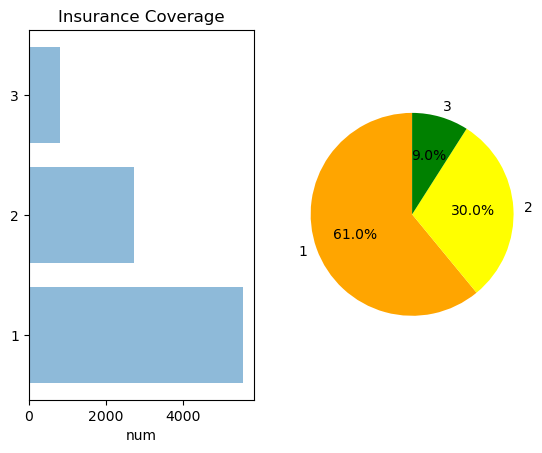

In [124]:
def class_num_visualize(df):
    all_class = list(df['Coverage'].unique())
    num_class = [sum(df['Coverage'] == ele) for ele in all_class]
    y_pos = np.arange(len(all_class))
    colors=['orange', 'yellow', 'green']
    plt.subplot(1, 2, 1)
    plt.barh(y_pos, num_class, align='center', alpha=0.5)
    plt.yticks(y_pos, all_class)
    plt.xlabel('num')
    plt.title('Insurance Coverage')
    plt.subplot(1, 2, 2)
    colors=['orange', 'yellow', 'green']
    plt.pie(num_class,labels=all_class, colors=colors, startangle=90, autopct='%1.1f%%')
    plt.axis('equal')

    plt.show()

 
class_num_visualize(df_transfered) #indicates there is no obvious imbalanced class
#'Premium': 3, 'Extended': 2, 'Basic': 1

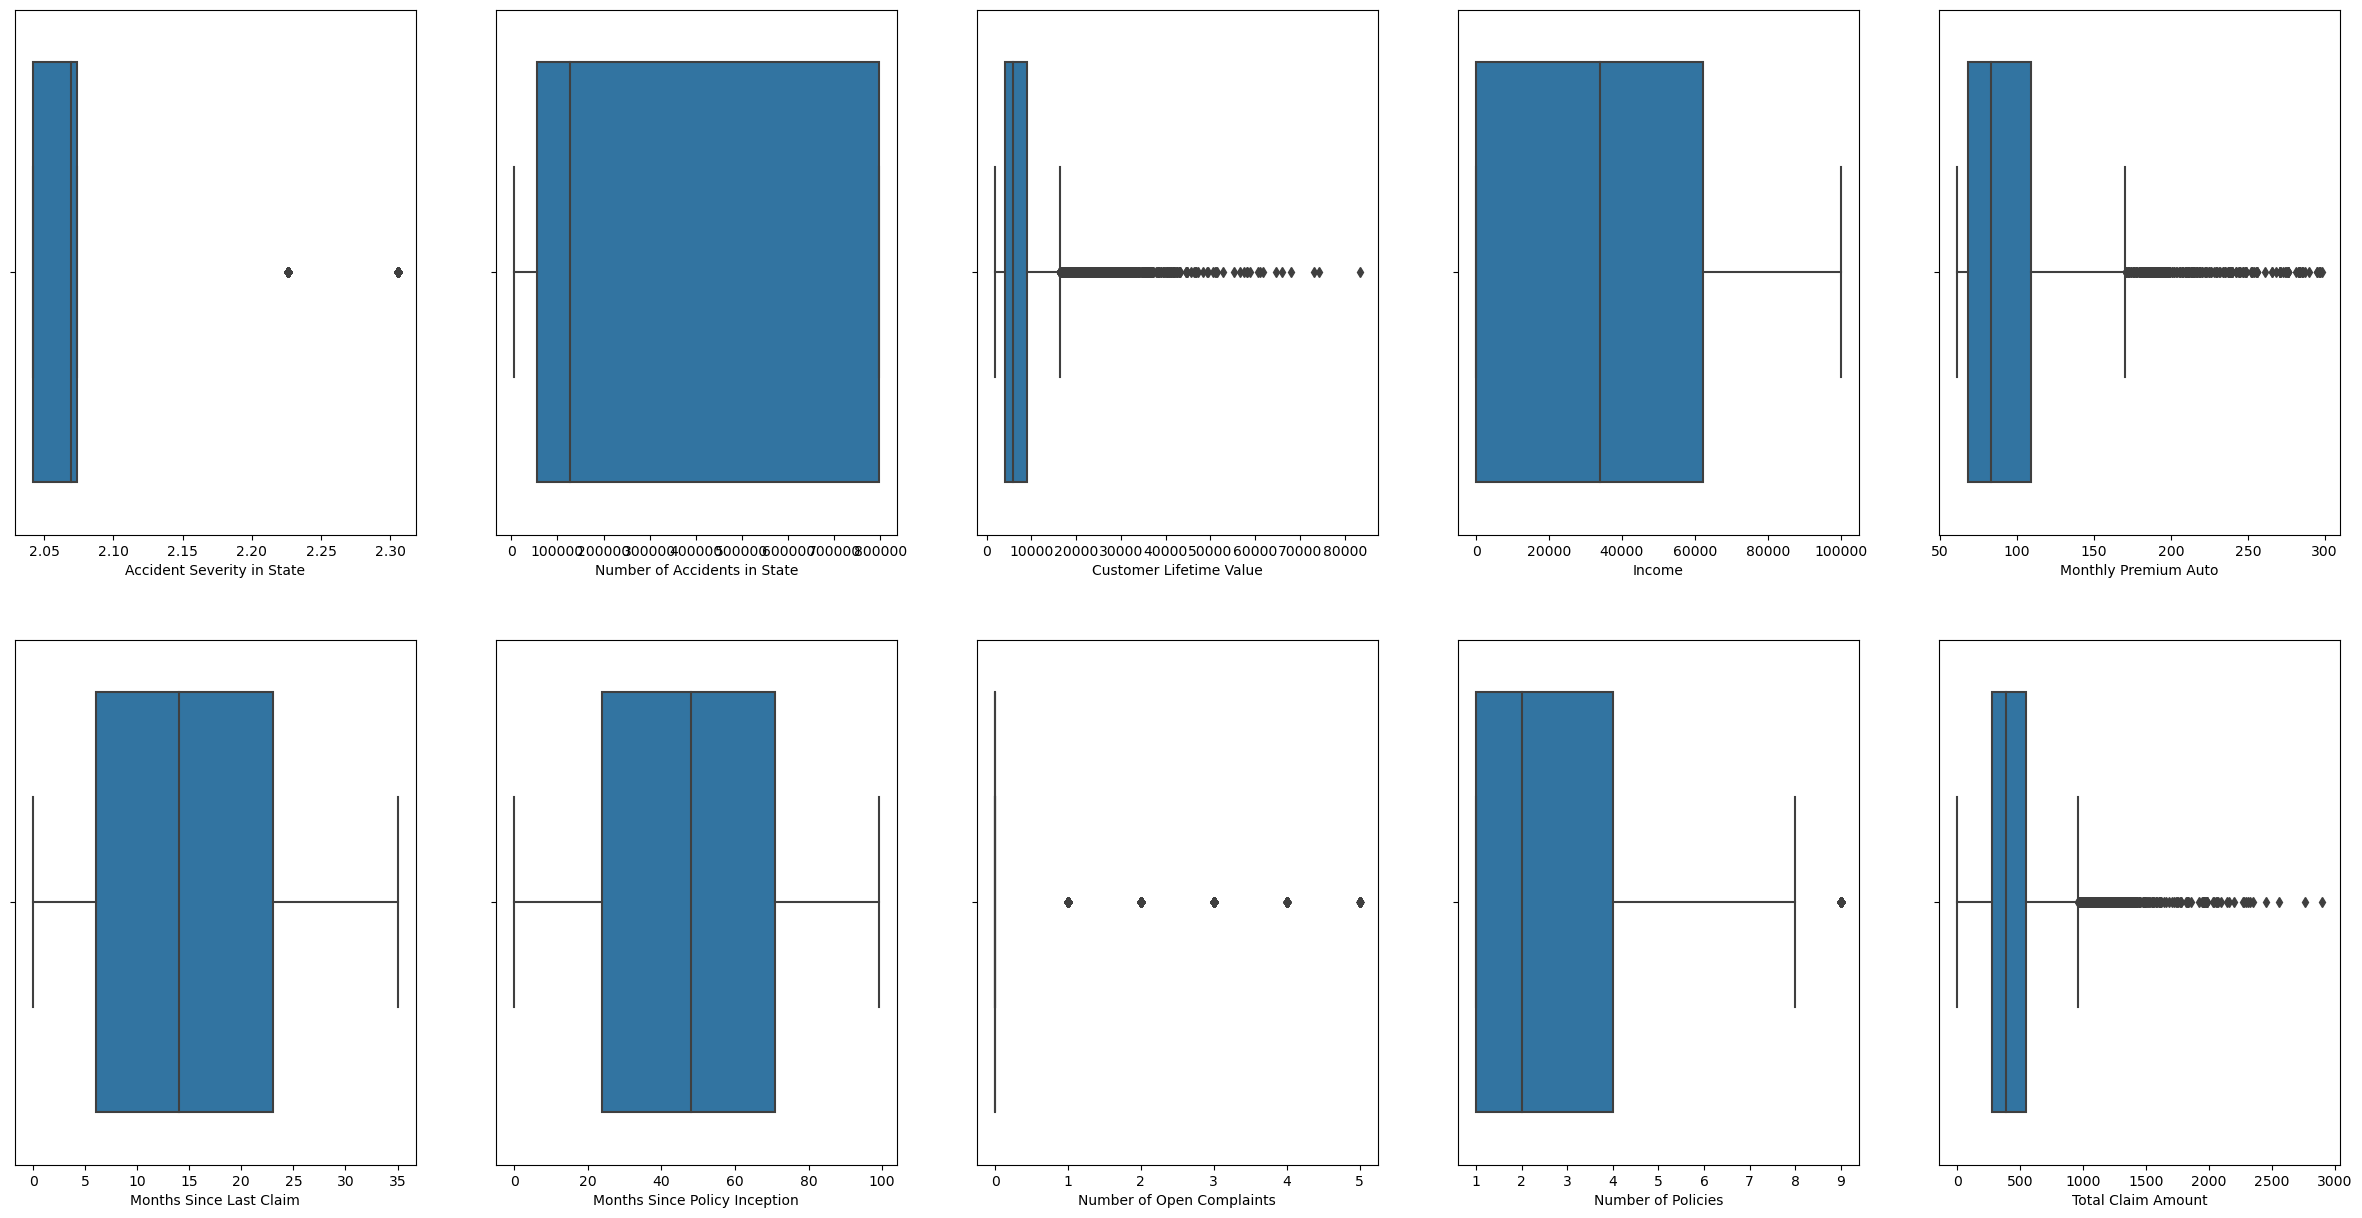

In [125]:
def check_outlier(df):
    col = num_list #all numerical columns
    fig = plt.figure(figsize= (30, 15))
    for index, coln in enumerate(col):
        ax = fig.add_subplot(2, 5, index +1)
        ax = sns.boxplot(x=df[coln])

check_outlier(df_transfered)

In [126]:
#detect the outliers, check if the box plot really indicate the outlier
'''
As the output indicated, the "outliers" are not really outlier since they are occupying a unignorable percentage of all the values, so I would keep
them for a while.
'''
def outlier_detect(df, num_list, threshold = 1.5):
    for ele in num_list:
        lower_quantile = df[ele].quantile(0.25)
        upper_quantile = df[ele].quantile(0.75)
        upper_limit = upper_quantile + threshold*(upper_quantile - lower_quantile)
        print(ele)
        print("number of outliers: ", len(df.loc[df[ele] > upper_limit]))
        print("percentage of outliers: ",len(df.loc[df[ele] > upper_limit])/len(df))
        print('*********************************************')

outlier_detect(df_transfered, num_list)

Accident Severity in State
number of outliers:  1680
percentage of outliers:  0.1839281804247865
*********************************************
Number of Accidents in State
number of outliers:  0
percentage of outliers:  0.0
*********************************************
Customer Lifetime Value
number of outliers:  817
percentage of outliers:  0.08944602583753011
*********************************************
Income
number of outliers:  0
percentage of outliers:  0.0
*********************************************
Monthly Premium Auto
number of outliers:  430
percentage of outliers:  0.047076855703963215
*********************************************
Months Since Last Claim
number of outliers:  0
percentage of outliers:  0.0
*********************************************
Months Since Policy Inception
number of outliers:  0
percentage of outliers:  0.0
*********************************************
Number of Open Complaints
number of outliers:  1882
percentage of outliers:  0.20604335449967157


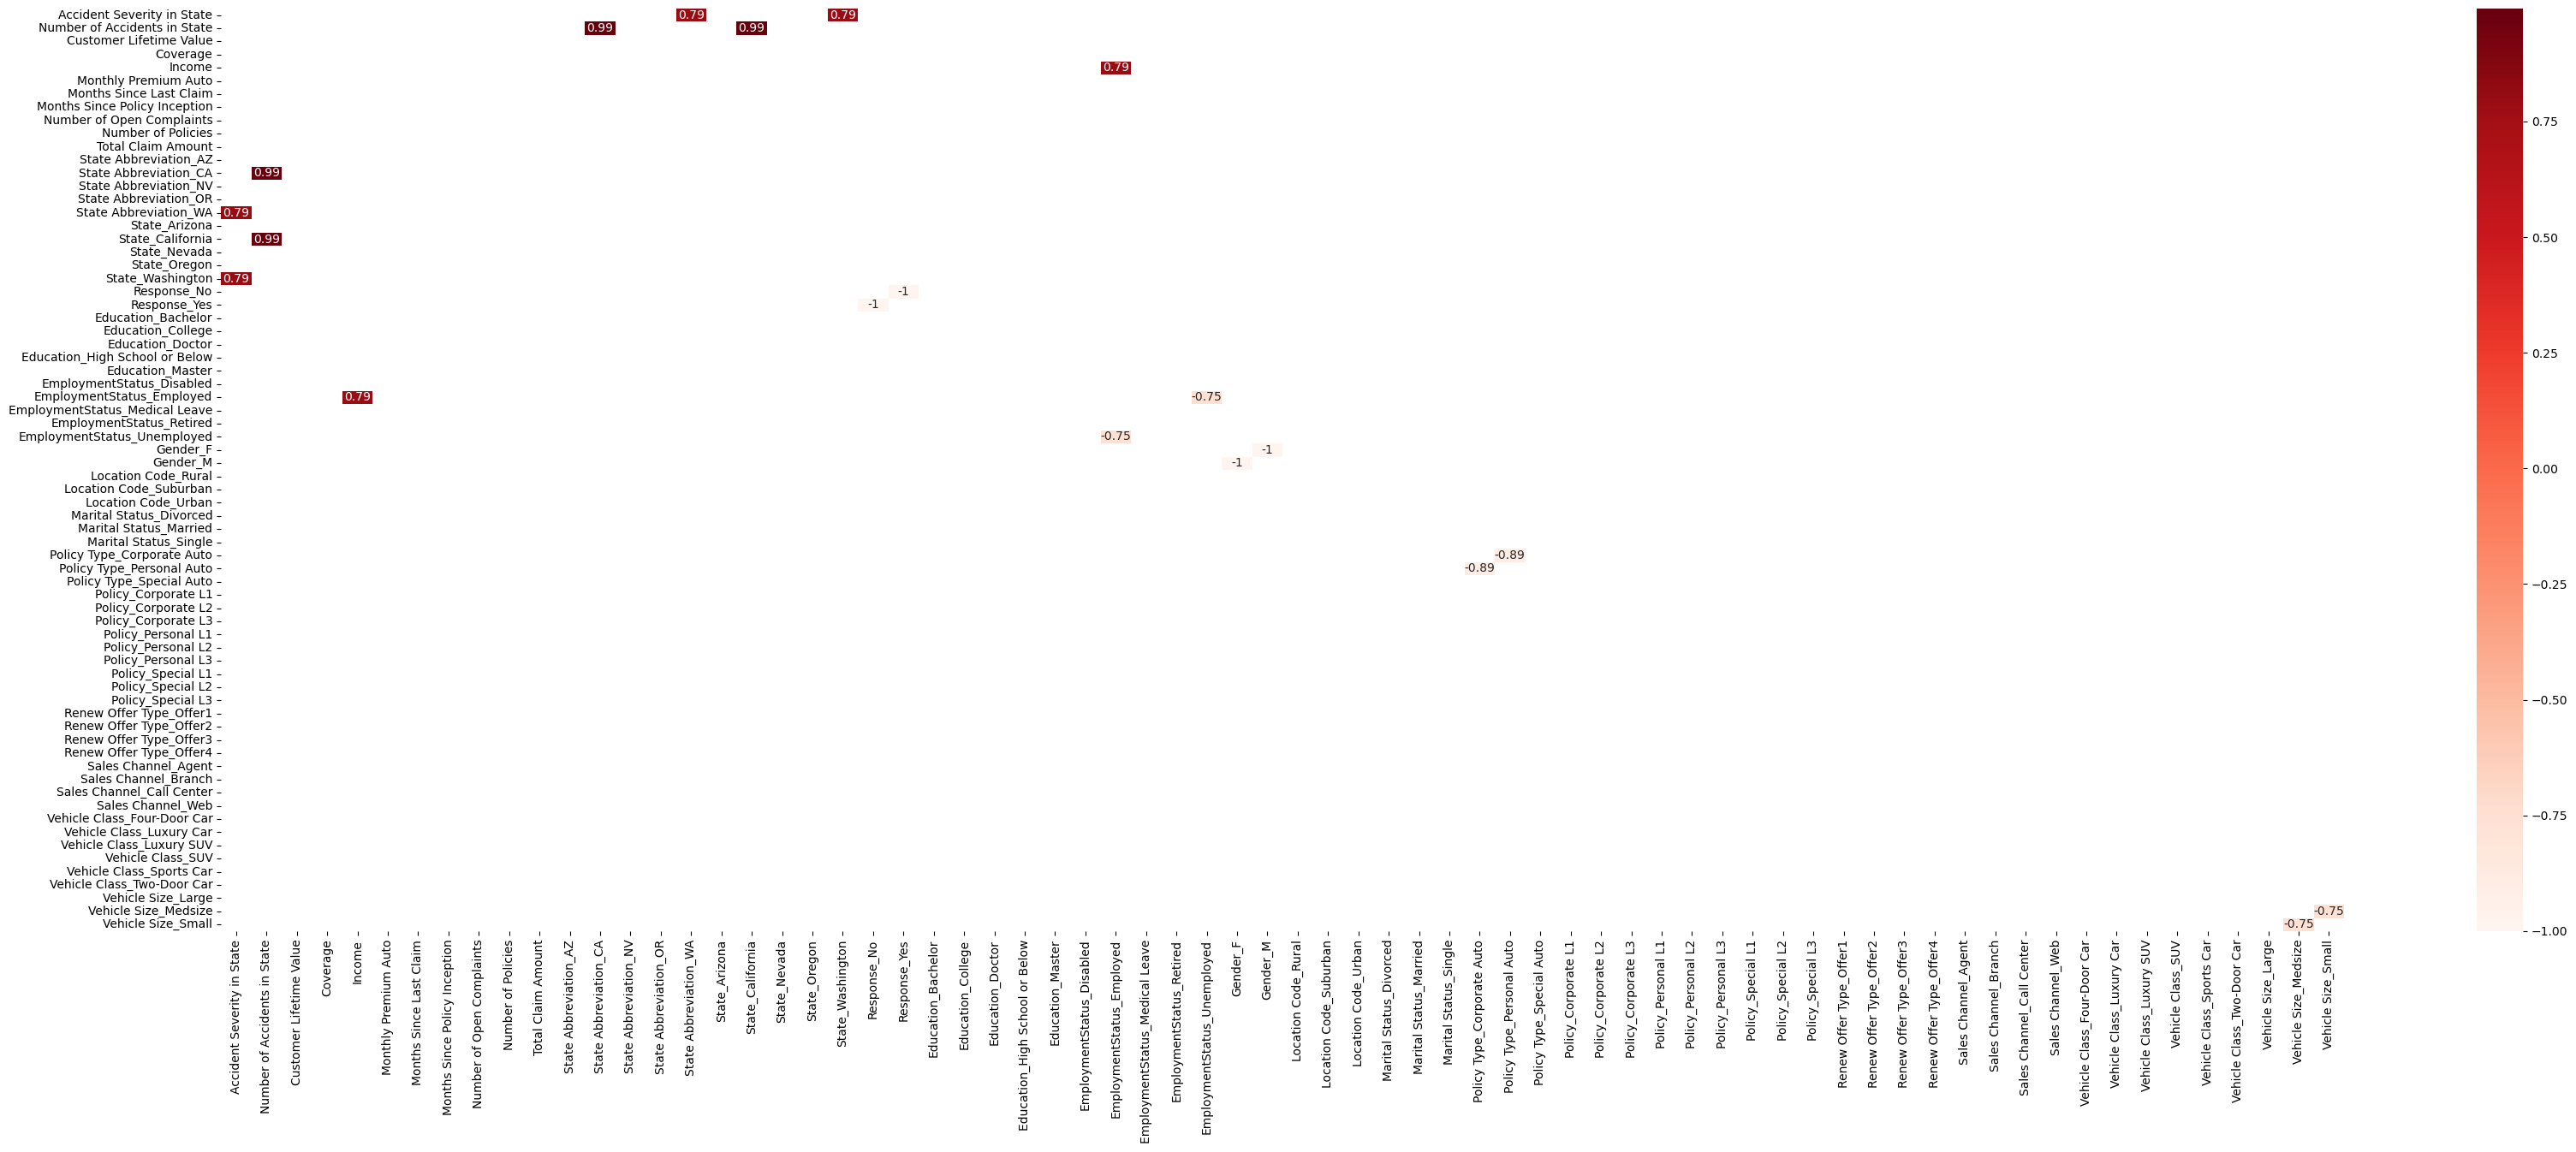

In [127]:
#check the correlation between features
def check_corr(df, bound = 0.75):
    #draw the correlation graph
    dfCorr = df.corr()
    filteredDf = dfCorr[((dfCorr >= bound) | (dfCorr <= -bound)) & (dfCorr !=1.000)]
    plt.figure(figsize=(40,14))
    sns.heatmap(filteredDf, annot=True, cmap="Reds")

    #list the high correlation pairs
    flattenDf = filteredDf.unstack().sort_values().drop_duplicates()

    
    return flattenDf, plt

flattenDf, plt = check_corr(df_transfered, bound = 0.75)
plt.show()

In [128]:
flattenDf

Gender_M                    Gender_F                       -1.000000
Response_No                 Response_Yes                   -1.000000
Policy Type_Personal Auto   Policy Type_Corporate Auto     -0.891417
Vehicle Size_Medsize        Vehicle Size_Small             -0.753241
EmploymentStatus_Employed   EmploymentStatus_Unemployed    -0.750760
State_Washington            Accident Severity in State      0.785051
EmploymentStatus_Employed   Income                          0.793875
State Abbreviation_CA       Number of Accidents in State    0.993953
Accident Severity in State  Accident Severity in State           NaN
dtype: float64

In [129]:
#as it indicated, obvioudly gender and response only have two possibilities for each of them, so we can delete Gender_M and Response_No
df_transfered.drop(['Gender_M',  'Response_No', 'State Abbreviation_CA'], axis = 1, inplace = True)

In [130]:
#use label encoder to transfer the class column and get the train/test
def prepare_data(df):

    scaler = StandardScaler()

    df[num_list] = scaler.fit_transform(df[num_list]) #scaling the features

    df = df.sample(frac=1).reset_index(drop=True) #shuffle the data and reset index
    y = df['Coverage']
    X = df.loc[:, df.columns!='Coverage']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = prepare_data(df_transfered)

In [131]:
X_train.shape

(6393, 66)

In [132]:
score_dict = {}
lr = LogisticRegression(C = 0.1)
lr.fit(X_train, y_train)
y_predict_lr = lr.predict(X_test)
print("Logistic Regression\n")
print("Accuracy Score :",lr.score(X_test, y_test),"\n")

print("*****************************************************\n")
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=10)
rfc.fit(X_train, y_train)
y_predict_rfc = rfc.predict(X_test)
print("RFC\n")
print("Accuracy Score :",rfc.score(X_test, y_test),"\n")
score_dict["RFC"] = rfc.score(X_test, y_test)
cm_rfc = confusion_matrix(y_test, y_predict_rfc)

print("*****************************************************\n")
svm = SVC(kernel="linear", probability=True)
svm.fit(X_train, y_train)
y_predict_svm = svm.predict(X_test)
print("SVM\n")
print("Accuracy Score :",svm.score(X_test, y_test),"\n")
score_dict["SVM"] = svm.score(X_test, y_test)
cm_svm = confusion_matrix(y_test, y_predict_svm)

print("*****************************************************\n")

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)
print("KNN\n")
print("Accuracy Score :",knn.score(X_test, y_test),"\n")
score_dict["KNN"] = knn.score(X_test, y_test)
cm_knn = confusion_matrix(y_test, y_predict_knn)

print("*****************************************************\n")


nb = GaussianNB()
nb.fit(X_train, y_train)
y_predict_nb = nb.predict(X_test)
print("NB\n")
print("Accuracy Score :",nb.score(X_test, y_test),"\n")
score_dict["NB"] = nb.score(X_test, y_test)
cm_nb = confusion_matrix(y_test, y_predict_nb)

print("*****************************************************\n")

GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)
y_predict_GBC = GBC.predict(X_test)
print("GBC\n")
print("Accuracy Score :",GBC.score(X_test, y_test),"\n")
score_dict["GBC"] = GBC.score(X_test, y_test)
cm_GBC = confusion_matrix(y_test, y_predict_GBC)

print("*****************************************************\n")

/Users/wesley/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression

Accuracy Score : 0.8080992338562568 

*****************************************************

RFC

Accuracy Score : 0.983582634075155 

*****************************************************

SVM

Accuracy Score : 0.9638817949653411 

*****************************************************

KNN

Accuracy Score : 0.6384531192995258 

*****************************************************

NB

Accuracy Score : 0.5946734768332725 

*****************************************************

GBC

Accuracy Score : 1.0 

*****************************************************



In [133]:
#check the confusion matrix in the logistic regression model

#even with the highest 
confusion_matrix(y_test, y_predict_lr)

array([[1632,   40,    0],
       [ 293,  524,   11],
       [   0,  182,   59]])

In [134]:
df_transfered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, BU79786 to Y167826
Data columns (total 67 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Accident Severity in State      9134 non-null   float64
 1   Number of Accidents in State    9134 non-null   float64
 2   Customer Lifetime Value         9134 non-null   float64
 3   Coverage                        9134 non-null   int64  
 4   Income                          9134 non-null   float64
 5   Monthly Premium Auto            9134 non-null   float64
 6   Months Since Last Claim         9134 non-null   float64
 7   Months Since Policy Inception   9134 non-null   float64
 8   Number of Open Complaints       9134 non-null   float64
 9   Number of Policies              9134 non-null   float64
 10  Total Claim Amount              9134 non-null   float64
 11  State Abbreviation_AZ           9134 non-null   uint8  
 12  State Abbreviation_NV         

In [135]:

new_cat_col = [x for x in list(df_transfered.columns) if x not in num_list and x not in ['Coverage']]
df_SMOTE = pd.concat([df_transfered[num_list], df_transfered[new_cat_col], df_transfered['Coverage']], axis = 1)
df_SMOTE.head()

,Accident Severity in State,Number of Accidents in State,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State Abbreviation_AZ,State Abbreviation_NV,State Abbreviation_OR,State Abbreviation_WA,State_Arizona,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Education_Bachelor,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Disabled,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_F,Location Code_Rural,Location Code_Suburban,Location Code_Urban,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Policy Type_Corporate Auto,Policy Type_Personal Auto,Policy Type_Special Auto,Policy_Corporate L1,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Policy_Special L1,Policy_Special L2,Policy_Special L3,Renew Offer Type_Offer1,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Agent,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Four-Door Car,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Large,Vehicle Size_Medsize,Vehicle Size_Small,Coverage
Customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BU79786,2.537321,-0.848126,-0.762878,0.612827,-0.703925,1.678099,-1.543287,-0.42225,-0.822648,-0.169640,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
QZ44356,-0.333651,-0.778530,-0.149245,-1.239617,0.022691,-0.208186,-0.217334,-0.42225,2.106160,2.400737,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,2
AI49188,1.574455,-0.924715,0.710636,0.365710,0.429596,0.288205,-0.360680,-0.42225,-0.404247,0.455734,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,3
WW63253,-0.669552,1.369956,-0.052263,-1.239617,0.371467,0.288205,0.606907,-0.42225,1.687759,0.329769,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1
HB64268,2.537321,-0.848126,-0.755575,0.203390,-0.587666,-0.307465,-0.145661,-0.42225,-0.822648,-1.018843,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1


In [136]:
df_SMOTE.shape


(9134, 67)

In [137]:
y = df_SMOTE['Coverage']
X = df_SMOTE.iloc[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

cat_index = list(range(len(num_list),66))
sm = SMOTENC(categorical_features=cat_index, random_state=42, sampling_strategy={1: 3895, 2: 3895, 3: 3895})
X_train_S, y_train_S = sm.fit_resample(X_train, y_train)

#Find out the new target incidency rate.
y_train_S.shape

(11685,)

In [138]:
y_train_S.value_counts(normalize=True) #proportion of coverage after SMOTENC

2    0.333333
1    0.333333
3    0.333333
Name: Coverage, dtype: float64

In [139]:
#train the model with the SMOTENC
score_dict = {}
lr = LogisticRegression(C = 0.1)
lr.fit(X_train_S, y_train_S)
y_predict_lr = lr.predict(X_test)
print("Logistic Regression\n")
print("Accuracy Score :",lr.score(X_test, y_test),"\n")

print("*****************************************************\n")
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=10)
rfc.fit(X_train_S, y_train_S)
y_predict_rfc = rfc.predict(X_test)
print("RFC\n")
print("Accuracy Score :",rfc.score(X_test, y_test),"\n")
score_dict["RFC"] = rfc.score(X_test, y_test)
cm_rfc = confusion_matrix(y_test, y_predict_rfc)

print("*****************************************************\n")
svm = SVC(kernel="linear", probability=True)
svm.fit(X_train_S, y_train_S)
y_predict_svm = svm.predict(X_test)
print("SVM\n")
print("Accuracy Score :",svm.score(X_test, y_test),"\n")
score_dict["SVM"] = svm.score(X_test, y_test)
cm_svm = confusion_matrix(y_test, y_predict_svm)

print("*****************************************************\n")

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_S, y_train_S)
y_predict_knn = knn.predict(X_test)
print("KNN\n")
print("Accuracy Score :",knn.score(X_test, y_test),"\n")
score_dict["KNN"] = knn.score(X_test, y_test)
cm_knn = confusion_matrix(y_test, y_predict_knn)

print("*****************************************************\n")


nb = GaussianNB()
nb.fit(X_train_S, y_train_S)
y_predict_nb = nb.predict(X_test)
print("NB\n")
print("Accuracy Score :",nb.score(X_test, y_test),"\n")
score_dict["NB"] = nb.score(X_test, y_test)
cm_nb = confusion_matrix(y_test, y_predict_nb)

print("*****************************************************\n")

GBC = GradientBoostingClassifier()
GBC.fit(X_train_S, y_train_S)
y_predict_GBC = GBC.predict(X_test)
print("GBC\n")
print("Accuracy Score :",GBC.score(X_test, y_test),"\n")
score_dict["GBC"] = GBC.score(X_test, y_test)
cm_GBC = confusion_matrix(y_test, y_predict_GBC)

print("*****************************************************\n")

/Users/wesley/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression

Accuracy Score : 0.8661072601240423 

*****************************************************

RFC

Accuracy Score : 0.9700839109813937 

*****************************************************

SVM

Accuracy Score : 0.9697190806275082 

*****************************************************

KNN

Accuracy Score : 0.5395840933965705 

*****************************************************

NB

Accuracy Score : 0.4060561838744984 

*****************************************************

GBC

Accuracy Score : 1.0 

*****************************************************



In [140]:
confusion_matrix(y_test, y_predict_lr)

array([[1626,   46,    1],
       [ 214,  559,   41],
       [   0,   65,  189]])

In [ ]:
#deep learning part
import tensorflow as tf
deep_model = tf.keras.Sequential()
input_layer = tf.keras.layers.Dense(2048, input_shape=(60,), activation = "relu")
#Add input layer to model object
deep_model.add(input_layer)

In [ ]:
#hidden layers
for i in range(5):
    deep_model.add(tf.keras.layers.Dense(2048, activation = "relu"))
    deep_model.add(tf.keras.layers.Dropout(0.5))

#output layers
deep_model.add(tf.keras.layers.Dense(4, activation = "softmax"))

In [23]:
deep_model.compile(optimizer = "adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])
results = deep_model.fit(X_train,y_train, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
200/200 [==============================] - 26s 129ms/step - loss: 0.6159 - accuracy: 0.7286 - val_loss: 0.3537 - val_accuracy: 0.8234
Epoch 2/10
200/200 [==============================] - 26s 129ms/step - loss: 0.3151 - accuracy: 0.8817 - val_loss: 0.2757 - val_accuracy: 0.9117
Epoch 3/10
200/200 [==============================] - 26s 129ms/step - loss: 0.2359 - accuracy: 0.9149 - val_loss: 0.2556 - val_accuracy: 0.9223
Epoch 4/10
200/200 [==============================] - 26s 131ms/step - loss: 0.1935 - accuracy: 0.9351 - val_loss: 0.2051 - val_accuracy: 0.9179
Epoch 5/10
200/200 [==============================] - 26s 131ms/step - loss: 0.1428 - accuracy: 0.9518 - val_loss: 0.2260 - val_accuracy: 0.9230
Epoch 6/10
200/200 [==============================] - 26s 128ms/step - loss: 0.1718 - accuracy: 0.9470 - val_loss: 0.1751 - val_accuracy: 0.9497
Epoch 7/10
200/200 [==============================] - 26s 129ms/step - loss: 0.1606 - accuracy: 0.9479 - val_loss: 0.1892 - val_ac